# YOUR PROJECT TITLE

### Ideer (inspireret af Samf B hjemmeopgave 2)
- Brug DST: tabel AUS07 til at vise udviklingen i bruttoledighed underinddelt i køn (stablet søjler evt. med linje der angive i alt)
- Brug DST: tabel AUS07 til at vise udviklingen i bruttoledighed underinddelt i alder
- Arbejdsstyrke?
- Brug DST: tabel AUS08 til at vise udviklingen i bruttoledighed underinddelt i region
- Evt. kig på ’discouraged worker-effect’ (ledige der trækker sig ud af arbejdsmarkedet ved høj arbejdsløshed). Her skal man se på om beskæftigelsen er faldet mere end ledigheden (bruttoledighed = RAM - find tabel - og (årlig)beskæftigelse = NABB19 -> findes der en statistik der opgører månedlig beskæftigelse? RAM skal sammenlignes med Nationalregnskabet)
- Brug DST: tabel EKSP04 (ledige og nyopslåede stillinger på jobnet) til at illustrere efterspørgslen efter arbejdskraft.
- Brug DST: tabel AUP01 (fuldtidsledige som pct. af arbejdsstyrken fordelt på alder og område)
- Brug DST: LBESK03 lønmodtagere efter branche. Udviklingen i ledigheden på tværs af erhver-agtigt


https://www.dst.dk/da/Statistik/nyt/NytHtml?cid=31501
 

Lav en slags tidslinje over begivenheder der kan have haft effekt på lededen/beskæftigelse. Eventuelt inkluder dem direkte i grafer


**Import packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import ipywidgets as widgets
plt.style.use('seaborn-whitegrid')
import datetime as dt
#from matplotlib_venn import venn2 # install with pip install matplotlib-venn

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject
#pip install git+https://github.com/elben10/pydst 
#to run this the above code needs to be installed in terminal

# Read and clean data

**Import package Pydst to get data using an API from Statistics Denmark**

In [2]:
import pydst

In [3]:
Dst = pydst.Dst(lang='en')
#Dst.get_tables(subjects=['INDKP107'])
Dst.get_subjects()
tables = Dst.get_tables(subjects=['04'])

**Getting data from table: AUS07**

In [4]:
data_aus07 = tables[tables.id=='AUS07']
data_aus07

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
113,AUS07,Unemployed persons (seasonally adjusted),-,2021-03-31 08:00:00,2007M01,2021M02,True,"[benefits, sex and age, seasonal adjustment an..."


In [5]:
aus_vars = Dst.get_variables(table_id='AUS07')
aus_vars

,id,text,elimination,time,values
0,YD,"benefits, sex and age",False,False,"[{'id': 'TOT', 'text': 'Gross unemployment'}, ..."
1,SAESONFAK,seasonal adjustment and actual figures,False,False,"[{'id': '9', 'text': 'Seasonally adjusted figu..."
2,Tid,time,False,True,"[{'id': '2007M01', 'text': '2007M01'}, {'id': ..."


In [6]:
for id in ['YD', 'SAESONFAK','Tid']:
    print(id)
    values = aus_vars.loc[aus_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')
#Bruttoledige består af de ikke-aktiverede (nettoledige) og aktiverede ledige.

YD
 id = TOT, text = Gross unemployment
 id = NET, text = Net unemployment
 id = LDP, text = Net unemployed recipients of unemployment benefits
 id = LKT, text = Net unemployed recipients of social assistance
 id = AKI, text = Activation total
 id = ADP, text = Activation of persons on unemployment benefits
 id = AKT, text = Activation of persons on social assistance (prepared for employment)
 id = MEN, text = Men
 id = KVR, text = Women
 id = U25, text = 16-24 years
 id = O25, text = 25-29 years
 id = O30, text = 30-39 years
 id = O40, text = 40-49 years
 id = O50, text = 50-59 years
 id = O60, text = 60 years and more
SAESONFAK
 id = 9, text = Seasonally adjusted figures in percent of the labour force
 id = 10, text = Seasonally adjusted
 id = 22, text = Enumerated actual figures  in percent of the labour force
 id = 24, text = Enumerated actual figures
Tid
 id = 2007M01, text = 2007M01
 id = 2007M02, text = 2007M02
 id = 2007M03, text = 2007M03
 id = 2007M04, text = 2007M04
 id = 20

In [7]:
variables = {'YD': ['TOT'], 'SAESONFAK': ['10'],'Tid': ['*']}
aus07 = Dst.get_data(table_id = 'AUS07', variables = variables)
aus07 = aus07.iloc[:,2:] #dropping column 'YD'
aus07.head()

,TID,INDHOLD
0,2008M11,79298.9
1,2008M12,85631.1
2,2009M01,92165.2
3,2009M02,101461.8
4,2009M03,111313.7


In [8]:
#gender
variables = {'YD': ['MEN', 'KVR'], 'SAESONFAK': ['10'],'Tid': ['*']}
aus07g = Dst.get_data(table_id = 'AUS07', variables = variables)
aus07g = aus07g.drop(['SAESONFAK'], axis=1)
#aus07g = aus07g.groupby(by=['TID','YD']).sum()
#aus07g = aus07.iloc[:,2:] #dropping column 'YD'
aus07g.head()


,YD,TID,INDHOLD
0,Men,2008M11,41784.7
1,Women,2008M11,37514.2
2,Men,2008M12,46140.0
3,Women,2008M12,39491.1
4,Men,2009M01,50841.0


In [9]:
#age
variables = {'YD': ['U25', 'O25', 'O30', 'O40', 'O50', 'O60'], 'SAESONFAK': ['10'],'Tid': ['*']}
aus07a = Dst.get_data(table_id = 'AUS07', variables = variables)
aus07a = aus07a.drop(['SAESONFAK'], axis=1)
#aus07g = aus07.iloc[:,2:] #dropping column 'YD'
aus07a.head()

,YD,TID,INDHOLD
0,16-24 years,2008M11,9691.3
1,25-29 years,2008M11,10757.5
2,30-39 years,2008M11,21992.2
3,40-49 years,2008M11,18097.3
4,50-59 years,2008M11,16196.2


Drop column ID

**Getting data from table: LBESK03**

In [10]:
data_lbesk03 = tables[tables.id=='LBESK03']
data_lbesk03
lbesk_vars = Dst.get_variables(table_id='LBESK03')
lbesk_vars

,id,text,elimination,time,values
0,BRANCHEDB071038,industry (DB07 10- and 19-grouping),True,False,"[{'id': 'TOT', 'text': 'TOT Industry, total'},..."
1,Tid,time,False,True,"[{'id': '2008M01', 'text': '2008M01'}, {'id': ..."


In [11]:
for id in ['BRANCHEDB071038','Tid']:
    print(id)
    values = lbesk_vars.loc[lbesk_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')
#Bruttoledige består af de ikke-aktiverede (nettoledige) og aktiverede ledige.

BRANCHEDB071038
 id = TOT, text = TOT Industry, total
 id = 1, text = 1 Agriculture, forestry and fishing
 id = A, text = A Agriculture, forestry and fishing
 id = 2, text = 2 Manufacturing, mining and quarrying, and utility services
 id = B, text = B Mining and quarrying
 id = C, text = C Manufacturing
 id = D, text = D Electricity, gas, steam and air conditioning supply
 id = E, text = E Water supply, sewerage and waste management
 id = 3, text = 3 Construction
 id = F, text = F Construction
 id = 4, text = 4 Trade and transport etc.
 id = G, text = G Wholesale and retail trade
 id = H, text = H Transportation
 id = I, text = I Accommodation and food service activities
 id = 5, text = 5 Information and communication
 id = J, text = J Information and communication
 id = 6, text = 6 Financial and insurance
 id = K, text = K Financial and insurance
 id = 7, text = 7 Real estate
 id = L, text = L Real estate activities
 id = 8, text = 8 Other business services
 id = M, text = M Knowledge

In [12]:
variables = {'BRANCHEDB071038': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'X'],'Tid': ['*']}
lbesk03 = Dst.get_data(table_id = 'LBESK03', variables = variables)
lbesk03.head()

variables = {'BRANCHEDB071038': ['TOT'],'Tid': ['*']}
lbesk031 = Dst.get_data(table_id = 'LBESK03', variables = variables)
lbesk031.head()

,BRANCHEDB071038,TID,INDHOLD
0,"TOT Industry, total",2008M01,2716275
1,"TOT Industry, total",2008M02,2719403
2,"TOT Industry, total",2008M03,2721268
3,"TOT Industry, total",2008M04,2722308
4,"TOT Industry, total",2008M05,2720736


**Getting data from table: LSK01**

In [13]:
data_lsk01 = tables[tables.id=='LSK01']
data_lsk01
lsk_vars = Dst.get_variables(table_id='LSK01')
lsk_vars

,id,text,elimination,time,values
0,BRANCHE,industry,True,False,"[{'id': '0', 'text': 'Total'}, {'id': '2', 'te..."
1,ENHED,unit,False,False,"[{'id': 'LS', 'text': 'Job vacancies (number)'..."
2,STØRRELSE,size,True,False,"[{'id': '000', 'text': 'Workplaces total'}, {'..."
3,Tid,time,False,True,"[{'id': '2010K1', 'text': '2010Q1'}, {'id': '2..."


In [14]:
for id in ['BRANCHE','ENHED', 'Tid']:
    print(id)
    values = lsk_vars.loc[lsk_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')

BRANCHE
 id = 0, text = Total
 id = 2, text = 2 Manufacturing, mining and quarrying, and utility services
 id = 3, text = 3 Construction
 id = 4, text = 4 Trade and transport etc.
 id = 5, text = 5 Information and communication
 id = 6-7, text = 6-7 Financial, insurance and real estate
 id = 8, text = 8 Other business services
ENHED
 id = LS, text = Job vacancies (number)
 id = ALS, text = Job vacancy rate (per cent)
Tid
 id = 2010K1, text = 2010Q1
 id = 2010K2, text = 2010Q2
 id = 2010K3, text = 2010Q3
 id = 2010K4, text = 2010Q4
 id = 2011K1, text = 2011Q1
 id = 2011K2, text = 2011Q2
 id = 2011K3, text = 2011Q3
 id = 2011K4, text = 2011Q4
 id = 2012K1, text = 2012Q1
 id = 2012K2, text = 2012Q2
 id = 2012K3, text = 2012Q3
 id = 2012K4, text = 2012Q4
 id = 2013K1, text = 2013Q1
 id = 2013K2, text = 2013Q2
 id = 2013K3, text = 2013Q3
 id = 2013K4, text = 2013Q4
 id = 2014K1, text = 2014Q1
 id = 2014K2, text = 2014Q2
 id = 2014K3, text = 2014Q3
 id = 2014K4, text = 2014Q4
 id = 2015K1, t

In [15]:
variables = {'BRANCHE': ['2', '3', '4', '5', '6-7', '8'], 'Enhed': ['LS'], 'Tid': ['*']}
lsk01 = Dst.get_data(table_id = 'LSK01', variables = variables)
lsk01.head()

variables = {'BRANCHE': ['0'], 'Enhed': ['LS'], 'Tid': ['*']}
lsk011 = Dst.get_data(table_id = 'LSK01', variables = variables)
lsk011.head()

,BRANCHE,ENHED,TID,STØRRELSE,INDHOLD
0,Total,Job vacancies (number),2010Q1,Workplaces total,19094.0
1,Total,Job vacancies (number),2010Q2,Workplaces total,20019.0
2,Total,Job vacancies (number),2010Q3,Workplaces total,19932.0
3,Total,Job vacancies (number),2010Q4,Workplaces total,17508.0
4,Total,Job vacancies (number),2011Q1,Workplaces total,19935.0


In [16]:
#vac = pd.DataFrame(lsk01)
lsk01.rename(columns = {'INDHOLD': 'jobvacancies', 'TID': 'TIME', 'BRANCHE': 'branche'}, inplace = True)
lsk01 = lsk01.drop(['ENHED', 'STØRRELSE'], axis=1)
lsk01.head()



,branche,TIME,jobvacancies
0,"2 Manufacturing, mining and quarrying, and uti...",2010Q1,2854.0
1,3 Construction,2010Q1,1362.0
2,4 Trade and transport etc.,2010Q1,7857.0
3,5 Information and communication,2010Q1,1666.0
4,"6-7 Financial, insurance and real estate",2010Q1,1422.0


In [17]:
lsk01['branch'] = lsk01['branche'].str[:1]
lsk01.head()

,branche,TIME,jobvacancies,branch
0,"2 Manufacturing, mining and quarrying, and uti...",2010Q1,2854.0,2
1,3 Construction,2010Q1,1362.0,3
2,4 Trade and transport etc.,2010Q1,7857.0,4
3,5 Information and communication,2010Q1,1666.0,5
4,"6-7 Financial, insurance and real estate",2010Q1,1422.0,6


# Merge data sets

In [50]:
dstmerge = pd.merge(aus07, lbesk03, how='outer', on=['TID']);
dstmerge.rename(columns = {'INDHOLD_x': 'Unemployed', 'INDHOLD_y': 'Employed', 'TID': 'TIME', 'BRANCHEDB071038': 'BRANCH'}, inplace = True)
#dstmerge.pd.date_to_time['TIME']

dstmerge['TIME'] = dstmerge['TIME'].str.replace(r'\D', '')
#dstmerge['YEAR'] = dstmerge['TIME'].str[:4]
#dstmerge['MD'] = dstmerge['TIME'].str[-2:]
dstmerge['branch'] = dstmerge['BRANCH'].str[:1]
dstmerge.head()

#unemployed - gross

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,TIME,Unemployed,BRANCH,Employed,branch
0,200811,79298.9,"A Agriculture, forestry and fishing",38581.0,A
1,200811,79298.9,B Mining and quarrying,4780.0,B
2,200811,79298.9,C Manufacturing,363401.0,C
3,200811,79298.9,"D Electricity, gas, steam and air conditioning...",12108.0,D
4,200811,79298.9,"E Water supply, sewerage and waste management",11739.0,E


In [51]:
dstmerge['TIME'] =  pd.to_datetime(dstmerge['TIME'],
                              format='%Y%m')

In [52]:
dstmerge.head(100)

,TIME,Unemployed,BRANCH,Employed,branch
0,2008-11-01,79298.9,"A Agriculture, forestry and fishing",38581.0,A
1,2008-11-01,79298.9,B Mining and quarrying,4780.0,B
2,2008-11-01,79298.9,C Manufacturing,363401.0,C
3,2008-11-01,79298.9,"D Electricity, gas, steam and air conditioning...",12108.0,D
4,2008-11-01,79298.9,"E Water supply, sewerage and waste management",11739.0,E
...,...,...,...,...,...
95,2009-03-01,111313.7,P Education,211469.0,P
96,2009-03-01,111313.7,Q Human health and social work,499277.0,Q
97,2009-03-01,111313.7,"R Arts, entertainment and recreation activities",47051.0,R
98,2009-03-01,111313.7,S Other service activities etc.,61449.0,S


In [19]:
dstmerge.dtypes

TIME           object
Unemployed    float64
BRANCH         object
Employed      float64
branch         object
dtype: object

In [20]:
#stmerge['TIME'] = dstmerge['TIME'].astype(str).astype(int)
#dstmerge['YEAR'] = dstmerge['YEAR'].astype(str).astype(int)
#dstmerge['MD'] = dstmerge['MD'].astype(str).astype(int)

In [21]:
dstmerge.dtypes

TIME           object
Unemployed    float64
BRANCH         object
Employed      float64
branch         object
dtype: object

In [22]:
dstmerge = dstmerge.dropna(axis=0)
dstmerge = dstmerge.sort_values('TIME')

In [23]:
dstmerge.head()

,TIME,Unemployed,BRANCH,Employed,branch
121,2008M01,80416.2,X Activity not stated,1425.0,X
120,2008M01,80416.2,S Other service activities etc.,61016.0,S
119,2008M01,80416.2,"R Arts, entertainment and recreation activities",45329.0,R
118,2008M01,80416.2,Q Human health and social work,483388.0,Q
117,2008M01,80416.2,P Education,207954.0,P


# Data Analysis

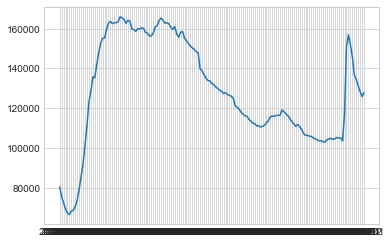

In [24]:
x = dstmerge['TIME']
y = dstmerge['Unemployed']
plt.plot(x,y)
plt.show()

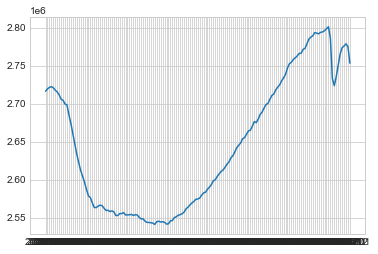

In [25]:
#bruger et subsæt af beskæftigede med total = industry
z = lbesk031['TID']
k = lbesk031['INDHOLD']
plt.plot(z,k)
plt.show()

ConversionError: Failed to convert value(s) to axis units: '2019M01'

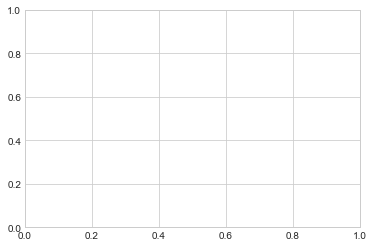

In [38]:
#ledige stillinger
#lav en interaktiv på denne
tid_ = lsk011['TID']
led_ = lsk011['INDHOLD']
plt.xticks('2019M01', '2020M12')
plt.plot(tid_,led_)
plt.show()

In [27]:
#unemploy - gender
#lav en interaktiv på denne
#gen_ = aus07g['YD']
#unem_ = aus07g['INDHOLD']
#plt.bar(gen_,unem_)
#plt.show()

In [28]:
labels = aus07g.TID.unique()
men = aus07g[aus07g['YD']=='Men']['INDHOLD']
women = aus07g[aus07g['YD']=='Women']['INDHOLD']
print(men, women)

0      41784.7
2      46140.0
4      50841.0
6      57082.1
8      63964.7
        ...   
331    67040.3
333    65450.2
335    63445.1
337    64194.7
339    65941.3
Name: INDHOLD, Length: 170, dtype: float64 1      37514.2
3      39491.1
5      41324.1
7      44379.7
9      47349.0
        ...   
330    64270.1
332    62932.2
334    62394.1
336    63715.2
338    65724.0
Name: INDHOLD, Length: 170, dtype: float64


In [29]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

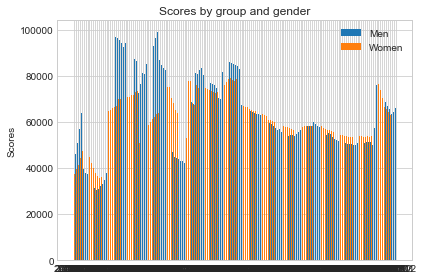

In [30]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men, width, label='Men')
rects2 = ax.bar(x + width/2, women, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [31]:
#lunemployment - age
#lav en interaktiv på denne
labels = aus07g.TID.unique()
U25 = aus07a[aus07a['YD']=='16-24 years']['INDHOLD']
O25 = aus07a[aus07a['YD']=='25-29 years']['INDHOLD']
O30 = aus07a[aus07a['YD']=='30-39 years']['INDHOLD']
O40 = aus07a[aus07a['YD']=='40-49 years']['INDHOLD']
O50 = aus07a[aus07a['YD']=='50-59 years']['INDHOLD']
O60 = aus07a[aus07a['YD']=='60 years and more']['INDHOLD']
print(U25)

0        9691.3
6       10599.3
12      11507.0
18      12747.5
24      14038.0
         ...   
995      7967.5
1001     7788.3
1007     7531.7
1013     7792.6
1019     8117.3
Name: INDHOLD, Length: 170, dtype: float64


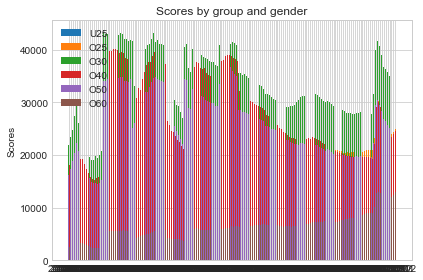

In [32]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, U25, width, label='U25')
rects2 = ax.bar(x + width/2, O25, width, label='O25')
rects3 = ax.bar(x - width/2, O30, width, label='O30')
rects4 = ax.bar(x + width/2, O40, width, label='O40')
rects5 = ax.bar(x - width/2, O50, width, label='O50')
rects6 = ax.bar(x + width/2, O60, width, label='O60')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [33]:
import ipywidgets as widgets 

def plot_employ(dstmerge, branch1):
    I = dstmerge['branch'] == branch1
    ax = dstmerge.loc[I,:].plot(x='TIME', y='Employed', style='-', legend=False)

widgets.interact(plot_employ,
    dstmerge = widgets.fixed(dstmerge),
    branch1 = widgets.Dropdown(description='Branch', 
                                options=dstmerge.branch.unique(),
                                value='A')
);

interactive(children=(Dropdown(description='Branch', index=10, options=('X', 'S', 'R', 'Q', 'P', 'O', 'N', 'M'…

In [34]:
#interaktiv på ledige stillinger

def plot_vac(lsk01, branch1):
    I = lsk01['branch'] == branch1
    ax = lsk01.loc[I,:].plot(x='TIME', y='jobvacancies', style='-', legend=False)

widgets.interact(plot_vac,
    lsk01 = widgets.fixed(lsk01),
    branch1 = widgets.Dropdown(description='Branch', 
                                options=lsk01.branch.unique(),
                                value='2')
);

interactive(children=(Dropdown(description='Branch', options=('2', '3', '4', '5', '6', '8'), value='2'), Outpu…

In [35]:
def _plot_timeseries(dataframe, variable, years):
    
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    
    dataframe.loc[:,['TIME']] = pd.to_numeric(dataframe['TIME'])
    I = (dataframe['TIME'] >= years[0]) & (dataframe['TIME'] <= years[1])
    
    x = dataframe.loc[I,'TIME'].unique()
    Ir = dataframe['branch'] == variable
    y = dataframe.loc[Ir,'branch']

    return x
    ax.plot(x,y)

    
    #ax = dataframe.loc[Ir,:].plot(x=x, y='Employed', style='-o', legend=False)

    ax.set_xticks(list(range(years[0], years[1] + 1, 5)))



def plot_timeseries(dataframe):
    
     widgets.interact(_plot_timeseries, 
     dataframe = widgets.fixed(dataframe),
     variable = widgets.Dropdown(
         description='variable', 
         options=dstmerge.branch.unique(), 
         value='A'),
     years=widgets.IntRangeSlider(
         description="years",
         min='2008M01',
         max='2021M01',
         value=['2008M01', '2021M01'],
         continuous_update=False,
      )                 
); 

In [36]:
#plot_timeseries(dstmerge)

**Emne: Vi ønsker at analysere arbejdsstyrken (de beskæftigede samt de ledige)**
* hvad sker der under corona?
* hvor mange bliver ledige, ryger de i aktivering?
* er der nogen som under corona (arbejdsstyrken?)
* efterspørgsel - ledige stillinger

Periode: før/efter corona (sammenligner 2019 med 2020)
1. Beskæftigelse + ledige (overordnet)
* 
2. Ledige 
* aktivering osv.
* efterspørgsel -> ledige stillinger (brancher)
* udgangspunkt i f.eks. brancher
3. Beskæftigelse
* branche før/efter corona

1. Udviklingen i bruttoledighed (mange år) (AUS07)
* interaktiv graf (ps 3)
* alder / køn evt.

2. Udviklingen i beskæftigelse (LBSK03)
* branche

3. Efterspørgsel
* vis ledige stillinger (LSK01)

4. konklusion







# Conclusion

ADD CONCISE CONLUSION.